In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
df_meta=pd.read_csv("Chest_xray_Corona_Metadata.csv",index_col=0)
df_meta.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


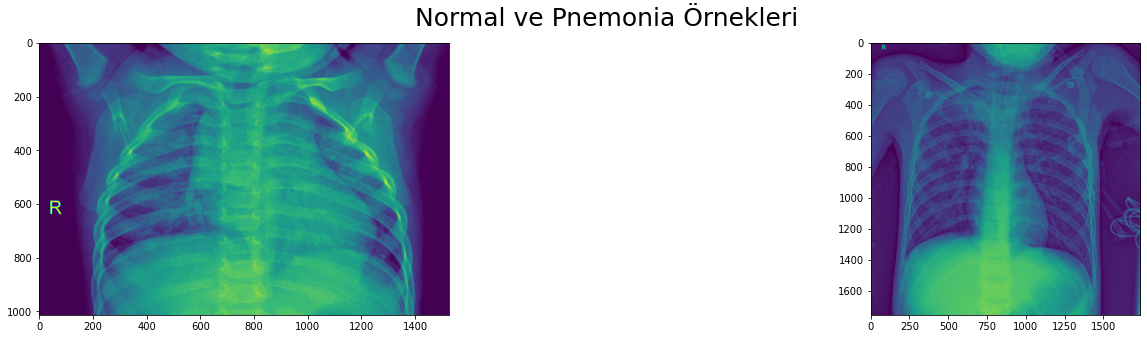

In [7]:
normal=df_meta[df_meta["Label"]=="Normal"].iloc[0]
pnemonia=df_meta[df_meta["Label"]=="Pnemonia"].iloc[0]
plt.figure(figsize=(25,5))
plt.suptitle(" Normal ve Pnemonia Örnekleri", fontsize="25")
plt.subplot(121)
plt.imshow(plt.imread("Coronahack-Chest-XRay-Dataset/"+
                      normal["Dataset_type"].lower()+"/"+normal["X_ray_image_name"]))

plt.subplot(122)
plt.imshow(plt.imread("Coronahack-Chest-XRay-Dataset/"+
                      pnemonia["Dataset_type"].lower()+"/"+pnemonia["X_ray_image_name"]))

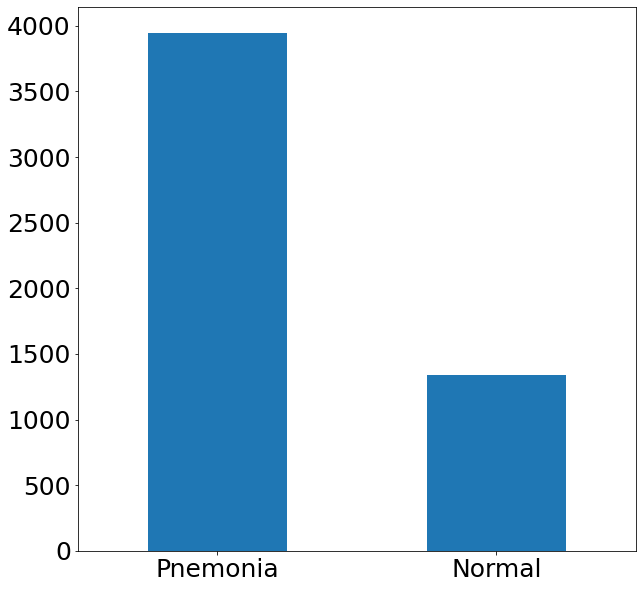

In [8]:
plt.figure(figsize=(10,10))
df_meta[df_meta["Dataset_type"]=="TRAIN"]["Label"].value_counts().plot.bar(rot=0)
plt.tick_params(labelsize=25)

DATA PREPOCESSING

Görüntü Büyütme

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,zoom_range=0.1,brightness_range=[0.5,1.3],
                                   width_shift_range=0.1,height_shift_range=0.1,validation_split=0.1)
test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [12]:
BATCH_SIZE=64
path="Coronahack-Chest-XRay-Dataset/"
train_images=train_datagen.flow_from_dataframe(dataframe=df_meta[df_meta["Dataset_type"]=="TRAIN"],x_col='X_ray_image_name',y_col='Label',color_mode='rgb',class_mode='categorical',
                                                target_size=(150,150),batch_size=BATCH_SIZE,shuffle=True,seed=1234,subset='training', directory=path+"/train")

val_images=train_datagen.flow_from_dataframe(dataframe=df_meta[df_meta["Dataset_type"]=="TRAIN"],x_col='X_ray_image_name',y_col='Label',color_mode='rgb',class_mode='categorical',
                                                target_size=(150,150),batch_size=BATCH_SIZE,shuffle=True,seed=1234,subset='validation', directory=path+"/train")

test_images = test_datagen.flow_from_dataframe(dataframe=df_meta[df_meta["Dataset_type"]=="TEST"],x_col='X_ray_image_name',y_col='Label',color_mode='rgb',class_mode='categorical',
                                                target_size=(150,150),batch_size=BATCH_SIZE,shuffle=False, directory=path+"/test")

Found 4758 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Model 


Sinir ağıyla transfer

In [34]:
inputs = tf.keras.layers.Input((150,150,3))
base_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(150,150,3), pooling='avg') 
x=base_model(inputs)
output=layers.Dense(2, activation='sigmoid')(x)
model=tf.keras.models.Model(inputs=inputs, outputs=output)

Model Eğitme

In [35]:
model.compile(Adamax(learning_rate=1e-4), loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_images, validation_data=val_images, epochs=30)

Epoch 1/30
75/75 [==============================] - 583s 8s/step - loss: 0.3187 - accuracy: 0.8995 - val_loss: 1.3926 - val_accuracy: 0.2822
Epoch 2/30
75/75 [==============================] - 805s 11s/step - loss: 0.1164 - accuracy: 0.9620 - val_loss: 0.5962 - val_accuracy: 0.7008
Epoch 3/30
75/75 [==============================] - 559s 7s/step - loss: 0.0821 - accuracy: 0.9756 - val_loss: 0.5768 - val_accuracy: 0.7500
Epoch 4/30
75/75 [==============================] - 540s 7s/step - loss: 0.0640 - accuracy: 0.9781 - val_loss: 0.3819 - val_accuracy: 0.8409
Epoch 5/30
75/75 [==============================] - 533s 7s/step - loss: 0.0656 - accuracy: 0.9792 - val_loss: 0.2772 - val_accuracy: 0.8902
Epoch 6/30
75/75 [==============================] - 622s 8s/step - loss: 0.0542 - accuracy: 0.9830 - val_loss: 0.2446 - val_accuracy: 0.9034
Epoch 7/30
75/75 [==============================] - 542s 7s/step - loss: 0.0415 - accuracy: 0.9859 - val_loss: 0.2382 - val_accuracy: 0.8939
Epoch 8/30
7

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
with plt.style.context(plt.style.available[8]):
    plt.suptitle("Accuracy and loss of train and validation set for each epoch.",fontsize=25)
    axes[0].plot(history.history["accuracy"],label="Train accuracy")
    axes[0].plot(history.history["val_accuracy"],label="Validation accuracy")
    axes[0].legend(fontsize=25)
    axes[0].tick_params(axis="both", labelsize=20)
    axes[0].set_xlabel("Epochs",fontsize=25)
    axes[0].set_ylabel("Accuracy",fontsize=25)
    
    axes[1].plot(history.history["loss"],label="Train loss")
    axes[1].plot(history.history["val_loss"],label="Validation loss")
    axes[1].legend(fontsize=25)
    axes[1].tick_params(axis="both", labelsize=20)
    axes[1].set_xlabel("Epochs",fontsize=25)
    axes[0].set_ylabel("Loss",fontsize=25)
    

In [ ]:
preds=model.predict(test_images)
preds = np.argmax(preds,axis=1)
preds=preds>0.5
gt=[0 if x=="Normal" else 1 for x in df_meta[df_meta["Dataset_type"]=="TEST"]["Label"]]
print("Test Setindeki Sonuçlar : ")
print(classification_report(gt,preds,target_names=["Normal","Phemonia"]))
print("ROC AUC score:   ",roc_auc_score(gt,preds))
print("F1 score:",f1_score(gt,preds))

In [ ]:
conf_matrix = confusion_matrix(gt, preds)
sns.heatmap(conf_matrix,xticklabels = ["Normal","Phemonia"], yticklabels =["Normal","Phemonia"],annot=True,fmt='g')
plt.title('Confusion Matrisi')
plt.show()